In [1]:
%matplotlib ipympl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
import sys
import pywt
import util

# interactive plotting with %matplotlib notebook

!ls ../recordings

2025-03-21_16-10_gain24_boardAds1299_vref4.5.csv
8ch.csv
battery.csv
march-25-test.csv


In [2]:
print('Load data and get properties\n')

fname = '8ch.csv'
df = pd.read_csv(f"../recordings/{fname}")
fname = '2025-03-21_16-10_gain24_boardAds1299_vref4.5.csv'

board, gain, Fs, vref, avss, resolution, vmid = util.get_board_attributes(fname)
channel_count = len([i for i in list(df.columns) if i.find('_raw_sample') !=-1])
len_minutes = (df['timestamp'].iloc[-1]-df['timestamp'].iloc[0])/1000000. / 60.

print(f"vref={vref}V, avss={avss}V, gain={gain}, sample_rate={Fs}hz, vmid={vmid}, resolution={resolution} bit")
print(f"\nchannel count= {channel_count}")
print(f"\ndata length= {int(len_minutes)}min {int((len_minutes%1)*60)}sec")

Load data and get properties

vref=4.5V, avss=0V, gain=24.0, sample_rate=250.0hz, vmid=2.25, resolution=24 bit

channel count= 4

data length= 6min 58sec


In [3]:
df = util.add_time_and_raw_voltage_columns(df, fname)

# Trime first and last
remove_first_seconds = 40
remove_last_seconds = 8
max_time = df['time_sec'].max()
df = df[(df['time_sec'] >= remove_first_seconds) & (df['time_sec'] <= (max_time - remove_last_seconds))].reset_index(drop=True)

df

added these new columns, ['time_sec', 'ch1_raw_voltage', 'ch2_raw_voltage', 'ch3_raw_voltage', 'ch4_raw_voltage']


,timestamp,ch1_voltage,ch2_voltage,ch3_voltage,ch4_voltage,ch1_raw_sample,ch2_raw_sample,ch3_raw_sample,ch4_raw_sample,time_sec,ch1_raw_voltage,ch2_raw_voltage,ch3_raw_voltage,ch4_raw_voltage
0,1743534564184676,1.726488e-06,3.462186e-06,1.227155e-06,-1.453950e-07,7973322,8379294,8296718,-1286894,40.000,2.428218,2.437292,2.435446,2.221236
1,1743534564188676,4.146817e-06,4.494539e-06,3.889752e-06,9.010812e-07,7963709,8369446,8286850,-1289404,40.004,2.428003,2.437072,2.435226,2.221180
2,1743534564192676,-2.244825e-06,-1.367533e-06,-2.109927e-06,7.962635e-07,7977221,8382949,8299356,-1289688,40.008,2.428305,2.437374,2.435505,2.221173
3,1743534564196676,-5.229945e-06,-4.468400e-06,-5.228192e-06,-1.630673e-07,7988853,8388607,8311157,-1287295,40.012,2.428565,2.437500,2.435769,2.221227
4,1743534564200676,9.806351e-07,-3.296220e-07,6.436440e-07,-8.963008e-08,7976886,8382912,8300179,-1286608,40.016,2.428297,2.437373,2.435523,2.221242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92651,1743534934788676,-3.060495e-06,-2.973487e-06,-2.969596e-06,5.110272e-07,7987706,8305824,8272915,-1304043,410.604,2.428539,2.435650,2.434914,2.220852
92652,1743534934792676,-4.970728e-06,-4.922328e-06,-4.961108e-06,-2.118346e-07,7997251,8315303,8282526,-1301817,410.608,2.428752,2.435862,2.435129,2.220902
92653,1743534934796676,1.533130e-06,1.356600e-06,1.200089e-06,6.342265e-08,7984518,8303065,8270805,-1301516,410.612,2.428468,2.435588,2.434867,2.220909
92654,1743534934800676,4.962811e-06,4.783718e-06,4.782886e-06,1.044023e-06,7973524,8292255,8259932,-1303810,410.616,2.428222,2.435346,2.434624,2.220858


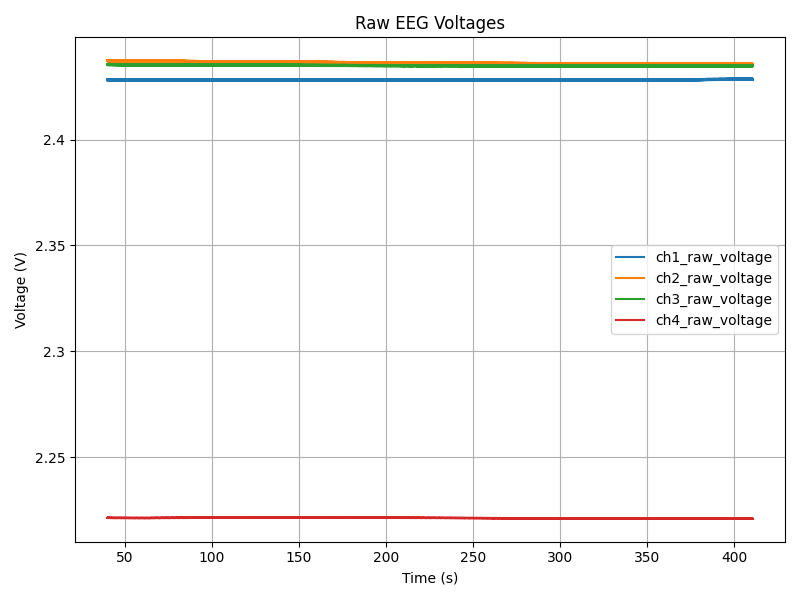

In [4]:
# time = df['time_sec'][df['time_sec'] >= 0]
raw_voltage_cols = util.get_raw_volt_cols(df)

# channels = ['ch1_raw_voltage', 'ch2_raw_voltage', 'ch3_raw_voltage', 'ch4_raw_voltage']
util.plot_raw_voltages(df, raw_voltage_cols)

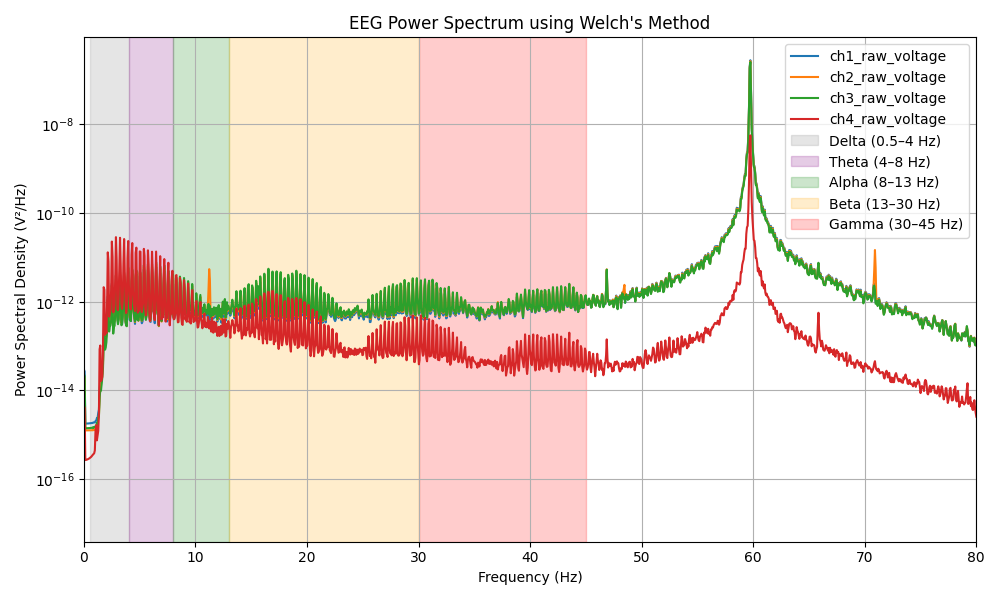

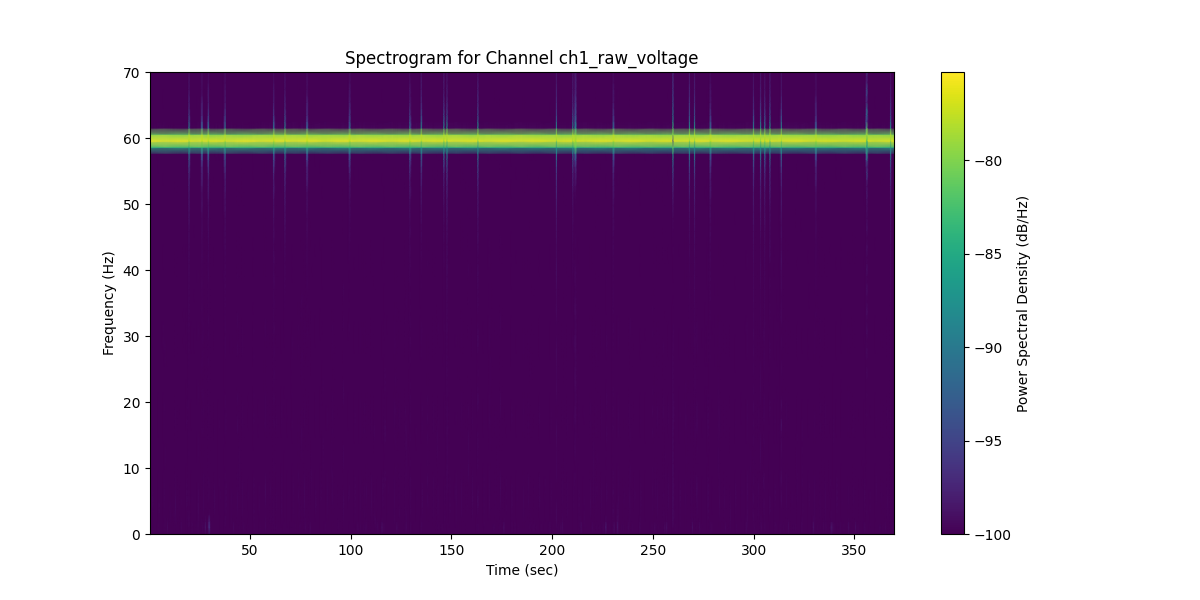

In [ ]:
# time = df['time_sec'][df['time_sec'] >= 0]
raw_voltage_cols = util.get_raw_volt_cols(df)

# channels = ['ch1_raw_voltage', 'ch2_raw_voltage', 'ch3_raw_voltage', 'ch4_raw_voltage']
util.plot_power_spectrum_welch(df, raw_voltage_cols, Fs, 2, 80, 4, 125)
_ = util.plot_spectrogram(df['ch1_raw_voltage'], Fs, 70)

/opt/homebrew/lib/python3.13/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


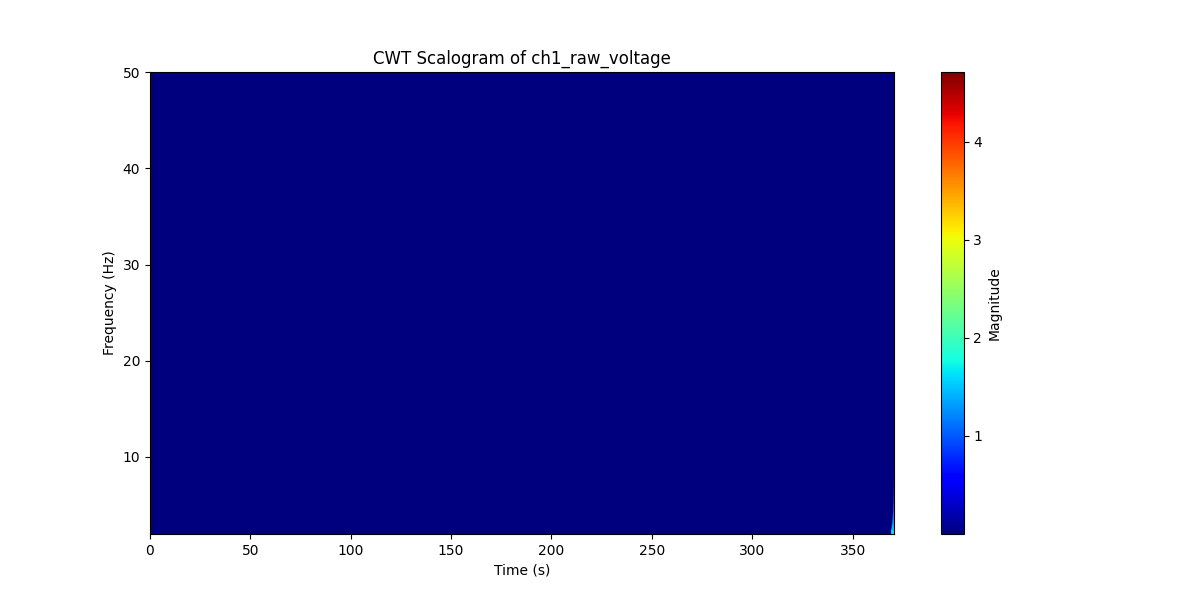

In [6]:
_ = util.plot_cwt(df['ch1_raw_voltage'], Fs, 2, 100, 196)